In [8]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("abdallahalidev/plantvillage-dataset")

print("Path to dataset files:", path)
gray_path = path + "/plantvillage dataset/grayscale"
print("Path para imagenes escala de grises: " + gray_path)

Path to dataset files: /root/.cache/kagglehub/datasets/abdallahalidev/plantvillage-dataset/versions/3
Path para imagenes escala de grises: /root/.cache/kagglehub/datasets/abdallahalidev/plantvillage-dataset/versions/3/plantvillage dataset/grayscale


In [9]:
import os
clases = ["Tomato___healthy", "Tomato___Late_blight", "Pepper,_bell___healthy", "Pepper,_bell___Bacterial_spot", "Corn_(maize)___healthy", "Corn_(maize)___Northern_Leaf_Blight"]
for clase in clases:
  ruta = gray_path + "/" + clase
  imagenes = os.listdir(ruta)
  print(len(imagenes))

1591
1909
1478
997
1162
985


In [10]:
import shutil
import os
import cv2
import numpy as np

def crear_data_con_filtro(carpeta_fuente, carpeta_destino, num):
  lower_green = np.array([30, 0, 10])
  upper_green = np.array([75, 255, 255])
  imagenes = os.listdir(carpeta_fuente)
  for i, nombreimg in enumerate(imagenes):
    if i < num:
      ruta = carpeta_fuente + '/' + nombreimg
      image = cv2.imread(ruta)
      if image is None:
          print("Error: No se pudo cargar la imagen.")
          continue
      hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
      mask = cv2.inRange(hsv_image, lower_green, upper_green)

      if not os.path.exists(carpeta_destino):
          os.makedirs(carpeta_destino)
      cv2.imwrite(carpeta_destino + '/' + nombreimg, mask)
  imagenes_salidas = os.listdir(carpeta_destino)
  print(len(imagenes_salidas))


In [11]:
import shutil
import os

def crear_data_grayscale(carpeta_fuente, carpeta_destino, num):
  imagenes = os.listdir(carpeta_fuente)
  if not os.path.exists(carpeta_destino):
          os.makedirs(carpeta_destino)
  for i, nombreimg in enumerate(imagenes):
    if i < num:
      #Copia de la carpeta fuente a la destino
      shutil.copy(carpeta_fuente + '/' + nombreimg, carpeta_destino + '/' + nombreimg)
  imagenes_salidas = os.listdir(carpeta_destino)
  print(len(imagenes_salidas))


In [12]:
def usar_funcion_de_carpetas(carpeta_fuente, carpeta_destino, clases, funcion, num):
  for clase in clases:
    fuente = carpeta_fuente + '/' + clase
    destino = carpeta_destino + '/' + clase
    funcion(fuente, destino, num)

In [14]:
#codigo para crear las carpetas balanceadas con filtro para verdes y mascara
cantidad = 985
fuente = "/root/.cache/kagglehub/datasets/abdallahalidev/plantvillage-dataset/versions/3/plantvillage dataset/segmented"
destino = "/content/dataset_segmented"
usar_funcion_de_carpetas(fuente, destino, clases, crear_data_con_filtro, cantidad)

985
985
985
985
985
985


In [13]:
#codigo para crear las carpetas balanceadas en escala de grises
cantidad = 985
fuente = gray_path
destino = "/content/dataset_grayscale"
classes = ["Tomato___healthy", "Tomato___Late_blight", "Pepper,_bell___healthy", "Pepper,_bell___Bacterial_spot", "Corn_(maize)___healthy", "Corn_(maize)___Northern_Leaf_Blight"]
usar_funcion_de_carpetas(fuente, destino, classes, crear_data_grayscale, cantidad)

985
985
985
985
985
985


In [ ]:
from tensorflow.keras import Sequential, layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# 1. Configurar rutas y parámetros
dataset_path = "/content/dataset_grayscale"  # Cambia esto a la ruta de tu dataset
target_size = (256, 256)  # Redimensionar a 256x256
batch_size = 32
epochs = 100
saved_models = "/content/saved_models"
# 2. Preprocesamiento y aumento de datos
datagen = ImageDataGenerator(
    rescale = 1.0/255.0,  # Normalización de píxeles
    rotation_range = 20,  # Rotación aleatoria
    width_shift_range = 0.2,  # Desplazamiento horizontal aleatorio
    height_shift_range = 0.2,  # Desplazamiento vertical aleatorio
    horizontal_flip = True,  # Volteo horizontal aleatorio
    validation_split = 0.2  # 20% de los datos para validación
)

# 3. Cargar las imágenes de las 4 clases
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size = target_size,
    color_mode = 'grayscale',  # Cargar en escala de grises
    batch_size = batch_size,
    class_mode = 'categorical',  # Clasificación multiclase
    classes = ['Tomato___healthy', 'Tomato___Late_blight', 'Pepper,_bell___healthy', 'Pepper,_bell___Bacterial_spot', 'Corn_(maize)___healthy', 'Corn_(maize)___Northern_Leaf_Blight'],  # Cuatro clases
    subset = 'training'  # Conjunto de entrenamiento
)

validation_generator = datagen.flow_from_directory(
    dataset_path,
    target_size = target_size,
    color_mode = 'grayscale',  # Cargar en escala de grises
    batch_size = batch_size,
    class_mode = 'categorical',  # Clasificación multiclase
    classes = ['Tomato___healthy', 'Tomato___Late_blight', 'Pepper,_bell___healthy', 'Pepper,_bell___Bacterial_spot', 'Corn_(maize)___healthy', 'Corn_(maize)___Northern_Leaf_Blight'],  # Cuatro clases
    subset = 'validation'  # Conjunto de validación
)

# 4. Construir el modelo
model = Sequential([
    layers.Conv2D(32, (3, 3), activation ='relu', input_shape =(256, 256, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation ='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation ='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation ='relu'),
    layers.Dense(6, activation ='softmax')  # Capa de salida para 4 clases
])

# 5. Compilar el modelo
model.compile(optimizer ='adam',
              loss ='categorical_crossentropy',  # Pérdida para clasificación multiclase
              metrics =['accuracy'])

# 6. Resumen del modelo
model.summary()
if not os.path.exists(saved_models):
  os.makedirs(saved_models)
filepath= "/content/saved_models/weights-improvement-{epoch:02d}-{val_accuracy:.2f}.keras" #File name includes epoch and validation accuracy.
#Use Mode = max for accuracy and min for loss.
checkpoint = ModelCheckpoint(filepath, monitor ='val_accuracy', verbose = 1, save_best_only = True, mode = 'max')
# 7. Callback para EarlyStopping
early_stop = EarlyStopping(
    monitor ='val_loss',  # Monitorear la pérdida en el conjunto de validación
    patience = 10,  # Número de épocas sin mejora antes de detener el entrenamiento
    restore_best_weights=True  # Restaurar los mejores pesos encontrados
)

callbacks_list = [checkpoint, early_stop]
# 8. Entrenar el modelo con EarlyStopping
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=epochs,
    callbacks=callbacks_list  # Añadir el callback de EarlyStopping
)

# 9. Evaluar el modelo
loss, accuracy = model.evaluate(validation_generator)
print(f"Pérdida en validación: {loss}")
print(f"Precisión en validación: {accuracy}")

# 10. Guardar el modelo
model.save("modelo_tomate_pepper_corn_balanceado_segmented_mask_early_stopping_.keras")

Found 4728 images belonging to 6 classes.
Found 1182 images belonging to 6 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      14,745,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,839,174 (56.61 MB)

 Trainable params: 14,839,174 (56.61 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.3474 - loss: 1.6843
Epoch 1: val_accuracy improved from -inf to 0.68924, saving model to /content/saved_models/weights-improvement-01-0.69.keras
147/147 ━━━━━━━━━━━━━━━━━━━━ 48s 275ms/step - accuracy: 0.3483 - loss: 1.6818 - val_accuracy: 0.6892 - val_loss: 0.8658
Epoch 2/100
  1/147 ━━━━━━━━━━━━━━━━━━━━ 10s 73ms/step - accuracy: 0.5938 - loss: 1.2100

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.68924
147/147 ━━━━━━━━━━━━━━━━━━━━ 7s 46ms/step - accuracy: 0.5938 - loss: 1.2100 - val_accuracy: 0.6814 - val_loss: 0.8559
Epoch 3/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.6458 - loss: 0.8979
Epoch 3: val_accuracy improved from 0.68924 to 0.71962, saving model to /content/saved_models/weights-improvement-03-0.72.keras
147/147 ━━━━━━━━━━━━━━━━━━━━ 36s 248ms/step - accuracy: 0.6459 - loss: 0.8976 - val_accuracy: 0.7196 - val_loss: 0.7358
Epoch 4/100
  1/147 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.6562 - loss: 0.9562
Epoch 4: val_accuracy improved from 0.71962 to 0.72569, saving model to /content/saved_models/weights-improvement-04-0.73.keras
147/147 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.6562 - loss: 0.9562 - val_accuracy: 0.7257 - val_loss: 0.7113
Epoch 5/100
147/147 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.7212 - loss: 0.7293
Epoch 5: val_accuracy improved from 0.72569 to 0.77431, saving model 

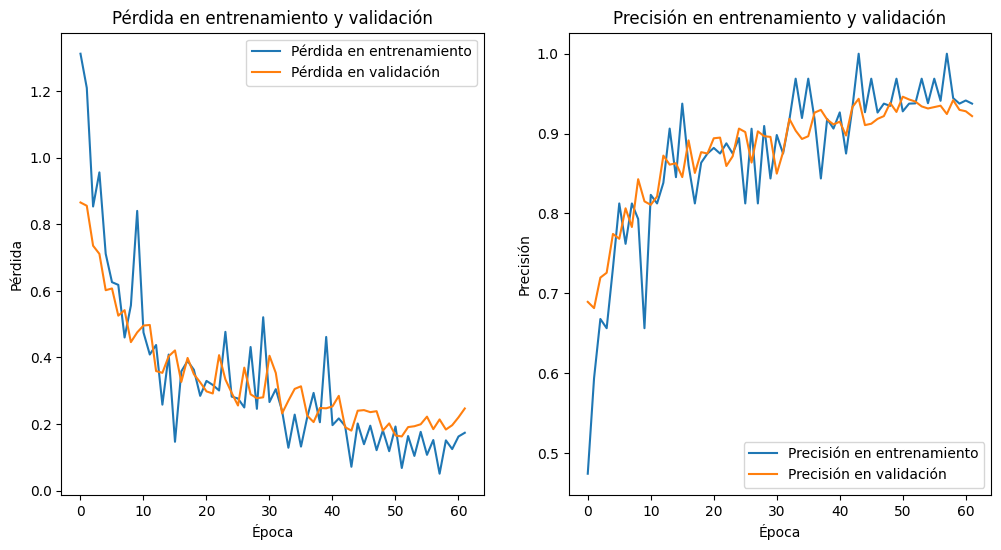

37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 190ms/step


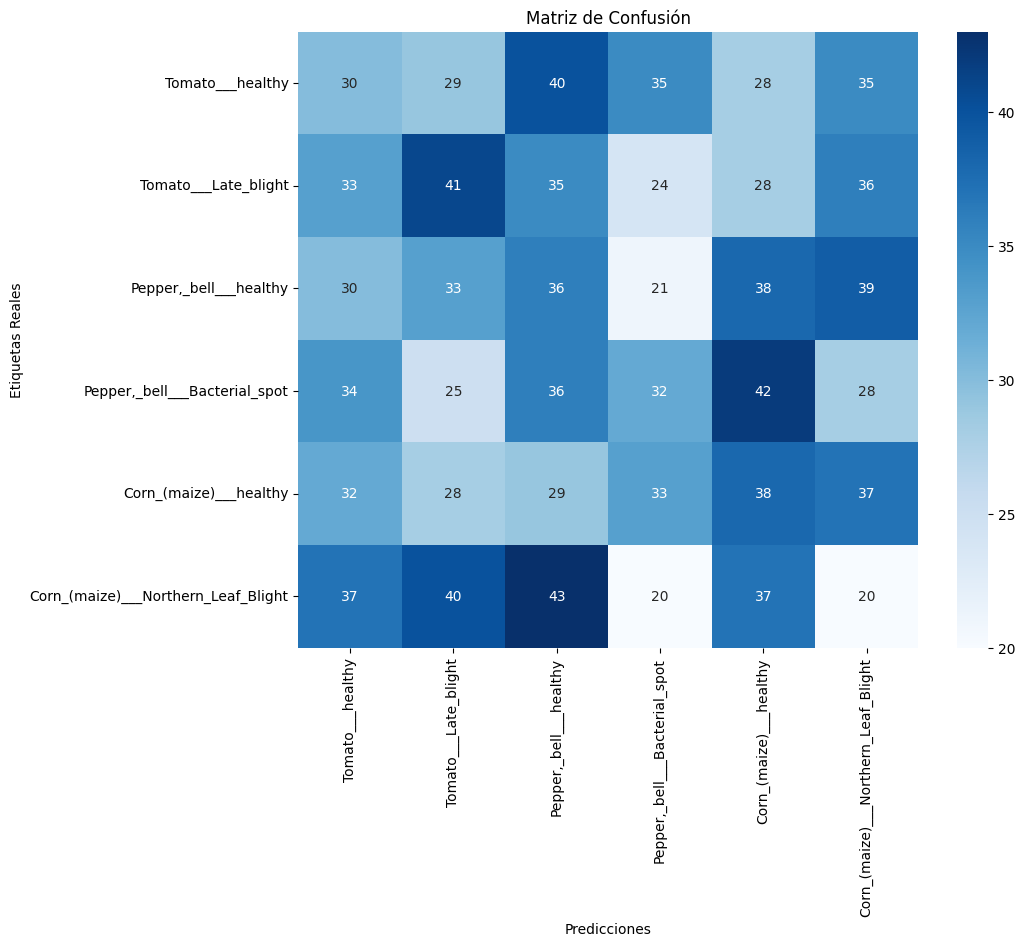

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 1. Graficar la pérdida y la precisión
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Pérdida en entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en validación')
plt.title('Pérdida en entrenamiento y validación')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Precisión en entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión en validación')
plt.title('Precisión en entrenamiento y validación')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()

plt.show()

# 2. Graficar la matriz de confusión
validation_generator.reset()
predictions = model.predict(validation_generator, steps=validation_generator.samples // batch_size + 1)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = validation_generator.classes[validation_generator.index_array[:len(predicted_classes)]]

conf_matrix = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=validation_generator.class_indices.keys(),
            yticklabels=validation_generator.class_indices.keys())
plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Etiquetas Reales')
plt.show()

In [ ]:
#Deteccion de enfermadades por captura de pantalla en tiempo real para el modelo a escala de grises
import cv2
import numpy as np
import tensorflow as tf
import pyautogui

# 1. Cargar el modelo entrenado
model = tf.keras.models.load_model("modelo_escala_de_grises.keras")

# 2. Definir el tamaño de la región de la pantalla a capturar
capture_width, capture_height = 256, 256  # Tamaño de la captura de pantalla
screen_width, screen_height = 400, 600  # Tamaño de la ventana de visualización

# 3. Definir las etiquetas de las clases
class_names = ['Tomate Sano', 'Tomate Enfermo', 'Pimenton Sano', 'Pimenton Enfermo', 'Maiz Sano', 'Maiz Enfermo']

# 4. Función para preprocesar la imagen
def preprocess_image(image):
    # Convertir a escala de grises
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Redimensionar a 256x256 (tamaño esperado por el modelo)
    resized_image = cv2.resize(gray_image, (256, 256))
    # Normalizar los valores de píxeles
    normalized_image = resized_image / 255.0
    # Expandir dimensiones para que coincida con la entrada del modelo (256, 256, 1)
    input_image = np.expand_dims(normalized_image, axis=-1)
    input_image = np.expand_dims(input_image, axis=0)  # Añadir dimensión del batch
    return input_image

# 5. Función para predecir todas las clases y sus confianzas
def predict_plant(image):
    # Preprocesar la imagen
    input_image = preprocess_image(image)
    # Realizar la predicción
    predictions = model.predict(input_image)
    # Obtener todas las clases y sus confianzas
    class_indices = np.argsort(predictions[0])[::-1]  # Orden descendente
    results = []
    for idx in class_indices:
        class_name = class_names[idx]
        confidence = predictions[0][idx]
        results.append((class_name, confidence))
    return results

# 6. Capturar la pantalla en tiempo real y realizar predicciones
print("Iniciando detección en tiempo real...")
while True:
    # Capturar la pantalla en la región específica (256x256)
    screenshot = pyautogui.screenshot(region=(290, 374, capture_width, capture_height))
    screenshot = np.array(screenshot)  # Convertir a un array de NumPy
    screenshot = cv2.cvtColor(screenshot, cv2.COLOR_RGB2BGR)  # Convertir a BGR (OpenCV usa BGR por defecto)

    # Realizar la predicción
    results = predict_plant(screenshot)

    # Crear una imagen en blanco para la ventana de visualización más grande
    display_image = np.zeros((screen_height, screen_width, 3), dtype=np.uint8)

    # Mostrar la captura de pantalla en la ventana más grande
    display_image[50:50 + capture_height, 50:50 + capture_width] = screenshot

    # Mostrar todas las clases y sus porcentajes de confianza
    y_offset = 340
    for i, (class_name, confidence) in enumerate(results):
        label = f"{class_name}: {confidence * 100:.2f}%"
        if label.startswith("P"):
            cv2.putText(display_image, label, (50, y_offset + i * 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        elif label.startswith("T"):
            cv2.putText(display_image, label, (50, y_offset + i * 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        elif label.startswith("M"):
            cv2.putText(display_image, label, (50, y_offset + i * 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)
    cv2.putText(display_image, "Presiona q para salir", (80, 560), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)
    # Mostrar la imagen en una ventana
    cv2.imshow("Deteccion de bienestar de cultivos", display_image)

    # Salir del bucle si se presiona la tecla 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Cerrar la ventana
cv2.destroyAllWindows()

In [ ]:
#Deteccion de enfermadades por captura de pantalla en tiempo real para el modelo con filtro de verdes y mascara
import cv2
import numpy as np
import tensorflow as tf
import pyautogui

# 1. Cargar el modelo entrenado
model = tf.keras.models.load_model("modelo_filtro_de_verdes.keras")

# 2. Definir el tamaño de la región de la pantalla a capturar
capture_width, capture_height = 256, 256  # Tamaño de la captura de pantalla
screen_width, screen_height = 400, 600  # Tamaño de la ventana de visualización
verdeBajo = np.array([27, 0, 10], np.uint8)
verdeAlto = np.array([75, 255, 255], np.uint8)
# 3. Definir las etiquetas de las clases
class_names = ['Tomate Sano', 'Tomate Enfermo', 'Pimenton Sano', 'Pimenton Enfermo', 'Maiz Sano', 'Maiz Enfermo']

# 4. Función para preprocesar la imagen
def preprocess_image(image):
    # Convertir a escala de grises
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)  # Convertir a BGqR (OpenCV usa BGR por defecto)
    image = cv2.inRange(image, verdeBajo, verdeAlto)
    # Redimensionar a 256x256 (tamaño esperado por el modelo)
    resized_image = cv2.resize(image, (256, 256))
    # Normalizar los valores de píxeles
    normalized_image = resized_image / 255.0
    # Expandir dimensiones para que coincida con la entrada del modelo (256, 256, 1)
    input_image = np.expand_dims(normalized_image, axis=-1)
    input_image = np.expand_dims(input_image, axis=0)  # Añadir dimensión del batch
    return input_image

# 5. Función para predecir todas las clases y sus confianzas
def predict_plant(image):
    # Preprocesar la imagen
    input_image = preprocess_image(image)
    # Realizar la predicción
    predictions = model.predict(input_image)
    # Obtener todas las clases y sus confianzas
    class_indices = np.argsort(predictions[0])[::-1]  # Orden descendente
    results = []
    for idx in class_indices:
        class_name = class_names[idx]
        confidence = predictions[0][idx]
        results.append((class_name, confidence))
    return results

# 6. Capturar la pantalla en tiempo real y realizar predicciones
print("Iniciando detección en tiempo real...")
while True:
    # Capturar la pantalla en la región específica (256x256)
    screenshot = pyautogui.screenshot(region=(290, 374, capture_width, capture_height))
    screenshot = np.array(screenshot)  # Convertir a un array de NumPy  # Convertir a BGR (OpenCV usa BGR por defecto)

    # Realizar la predicción
    results = predict_plant(screenshot)
    screenshot = cv2.cvtColor(screenshot, cv2.COLOR_RGB2BGR)
    # Crear una imagen en blanco para la ventana de visualización más grande
    display_image = np.zeros((screen_height, screen_width, 3), dtype=np.uint8)

    # Mostrar la captura de pantalla en la ventana más grande
    display_image[50:50 + capture_height, 50:50 + capture_width] = screenshot

    # Mostrar todas las clases y sus porcentajes de confianza
    y_offset = 340
    for i, (class_name, confidence) in enumerate(results):
        label = f"{class_name}: {confidence * 100:.2f}%"
        if label.startswith("P"):
            cv2.putText(display_image, label, (50, y_offset + i * 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        elif label.startswith("T"):
            cv2.putText(display_image, label, (50, y_offset + i * 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        elif label.startswith("M"):
            cv2.putText(display_image, label, (50, y_offset + i * 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)
    cv2.putText(display_image, "Presiona q para salir", (80, 560), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2)

    # Mostrar la imagen en una ventana
    cv2.imshow("Deteccion de bienestar de cultivos", display_image)

    # Salir del bucle si se presiona la tecla 'q'
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Cerrar la ventana
cv2.destroyAllWindows()